<a href="https://colab.research.google.com/github/nhattminh160901/lung_cancer_cell/blob/main/tw_ed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
np.version.version

'1.23.5'

In [ ]:
import numpy as np

In [ ]:
def filter_lines(lines):
    filtered_lines = []
    previous_r_line = lines[0]
    frist_line = True
    for r_theta in lines[1:]:
        if np.abs(r_theta[0][0]) - np.abs(previous_r_line[0][0])>150:
            if (frist_line):
                filtered_lines.append(previous_r_line)
                frist_line = False
            filtered_lines.append(r_theta)
            print(1, r_theta)
        previous_r_line = r_theta
    return filtered_lines

In [ ]:
def sort_lines(lines):
    sorted_lines = sorted(lines, key=lambda line: line[0][0])
    filtered_lines = sorted_lines
    return filtered_lines
#sort_lines(lines)

In [ ]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Returns closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [x0, y0]

In [ ]:
def target_points(horizontal_lines, vertical_lines):
    points = []
    try:
        points.append(intersection(horizontal_lines[0],vertical_lines[0]))
        points.append(intersection(horizontal_lines[0],vertical_lines[4]))
        points.append(intersection(horizontal_lines[4],vertical_lines[4]))
        points.append(intersection(horizontal_lines[4],vertical_lines[0]))
        return points
    except:
        return points


In [ ]:
def filter_data(input_data, e=0):
    rad_e = e * np.pi/180
    target_value_1 = (np.pi+rad_e) / 2
    tolerance_1 = np.pi / 50
    lower_bound_1 = target_value_1 - tolerance_1
    upper_bound_1 = target_value_1 + tolerance_1

    target_value_2 = rad_e
    tolerance_2 = np.pi / 50
    lower_bound_2 = target_value_2 - tolerance_2
    upper_bound_2 = target_value_2 + tolerance_2

    target_value_3 = np.pi + rad_e
    tolerance_3 = np.pi / 50
    lower_bound_3 = target_value_3 - tolerance_3
    upper_bound_3 = target_value_3 + tolerance_3

    filtered_data = []
    horizontal_lines =[]
    vertical_lines = []

    for item in input_data:
        if lower_bound_1 <= item[0, 1] <= upper_bound_1:
            #filtered_data.append(item)
            horizontal_lines.append(item)
        else:
            if lower_bound_2 <= item[0, 1] <= upper_bound_2:
                #filtered_data.append(item)
                vertical_lines.append(item)
            else:
                if lower_bound_3 <= item[0, 1] <= upper_bound_3:
                    #filtered_data.append(item)
                    vertical_lines.append(item)
    if (horizontal_lines):
        horizontal_lines = sort_lines(horizontal_lines)
        horizontal_lines = filter_lines(horizontal_lines)
    if (vertical_lines):
        vertical_lines = sort_lines(vertical_lines)
        vertical_lines = filter_lines(vertical_lines)
    filtered_data = horizontal_lines + vertical_lines

    return np.array(filtered_data), np.array(horizontal_lines), np.array(vertical_lines)

1 [[392.          1.5707964]]
1 [[584.          1.5707964]]
1 [[793.          1.5358897]]


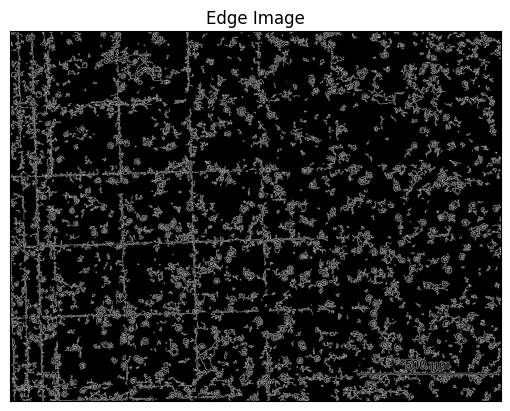

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


# read image
img = cv2.imread("1.jpg")

img2 = cv2.bitwise_and(img, img)

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Find edge with Canny edge detection
edges = cv2.Canny(img_gray, 45, 13)

lines = cv2.HoughLines(edges, 1, np.pi/90, 235)


filtered_lines_all = filter_data(lines, 0)

# lọc line
filtered_lines = filtered_lines_all[0]
#filtered_lines = lines

#filtered_lines = lines



# The below for loop runs till r and theta values
# are in the range of the 2d array
for r_theta in lines:
    arr = np.array(r_theta[0], dtype=np.float64)
    r, theta = arr
    # Stores the value of cos(theta) in a
    a = np.cos(theta)

    # Stores the value of sin(theta) in b
    b = np.sin(theta)

    # x0 stores the value rcos(theta)
    x0 = a*r

    # y0 stores the value rsin(theta)
    y0 = b*r

    # x1 stores the rounded off value of (rcos(theta)-1000sin(theta))
    x1 = int(x0 + 1500*(-b))

    # y1 stores the rounded off value of (rsin(theta)+1000cos(theta))
    y1 = int(y0 + 1500*(a))

    # x2 stores the rounded off value of (rcos(theta)+1000sin(theta))
    x2 = int(x0 - 1500*(-b))

    # y2 stores the rounded off value of (rsin(theta)-1000cos(theta))
    y2 = int(y0 - 1500*(a))

    # cv2.line draws a line in img from the point(x1,y1) to (x2,y2).
    # (0,0,255) denotes the colour of the line to be
    # drawn. In this case, it is red.
    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 255), 2)


points = target_points(filtered_lines_all[1],filtered_lines_all[2])
if points:
    for point in points:
        x, y = point
        cv2.circle(img, (x, y), 5, (0, 0, 255), 5)
#cv2.circle(img_gray, (0, 0), 5, (0, 0, 255), 5)


# All the changes made in the input image are finally
# written on a new image houghlines.jpg
cv2.imwrite('linesDetected.jpg', img)
if len(points) == 4:
    mask = np.zeros(img2.shape[0:2], dtype=np.uint8)
    points = np.array([points])
    #method 1 smooth region
    cv2.drawContours(mask, [points], -1, (255, 255, 255), -1, cv2.LINE_AA)
    res = cv2.bitwise_and(img2,img2,mask = mask)
    cv2.imwrite('croplinesDetected.jpg', res)



# display results
plt.imshow(img, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

img_corrected = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(edges, cmap='gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()